In [2]:
# Data wrangling
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt

# Math operations
import numpy as np

# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal

In [4]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [6]:
class NNMultistepModel():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal 
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

In [94]:
df = pd.read_csv('new_data.csv')
df = df.dropna()
ts = df[[
'huss', 
# 'f107', 
'siconc', 
# 'kp', 
# 'ap', 
# 'iprp', 
# 'ssn',
# 'tsi',
'scnum',
# 'iprm',
# 'iprg',
'scph',
'tas'
]].values
# Number of lags (hours back) to use for models
lag = 5000
# Steps ahead to forecast 
n_ahead = 1000
X, Y = create_X_Y(ts, lag=lag, n_ahead=n_ahead, target_index=4)
n_ft = X.shape[2]

In [95]:

# Share of obs in testing 
test_share = 0.15
# Epochs for training
epochs = 10
# Batch size 
batch_size = 256
# Learning rate
lr = 0.001
# Number of neurons in LSTM layer
n_layer = 10

In [96]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [98]:
# Initiating the model object
model = NNMultistepModel(
 X=Xtrain,
 Y=Ytrain,
 n_outputs=n_ahead,
 n_lag=lag,
 n_ft=n_ft,
 n_layer=n_layer,
 batch=batch_size,
 epochs=epochs, 
 lr=lr,
 Xval=Xval,
 Yval=Yval,
)
# Training of the model 
history = model.train()


Epoch 1/10
 8/37 [=====>........................] - ETA: 1:05 - loss: 0.4607

In [ ]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]

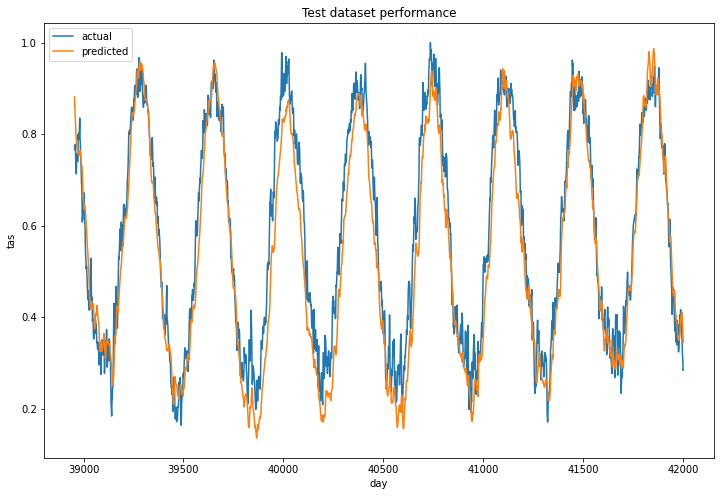

In [138]:
fc = df.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
plt.figure(figsize=(12, 8))
plt.plot(fc['day'], fc['tas'], label='actual')
plt.plot(fc['day'], fc['forecast'], label='predicted')
plt.xlabel("day")
plt.ylabel("tas")
plt.title("Test dataset performance")
plt.legend()
plt.show()

In [92]:
yhat = model.predict(Xval[-n_ahead:])[-1]
actual = Xval[-n_ahead:, -1, -1]

MSE = sum((yhat - actual)**2)/len(yhat)
from utilities import unnormalize
print(MSE, unnormalize(MSE**.5)-unnormalize.min_temp)

0.033306361039679946 1.1612129356785772


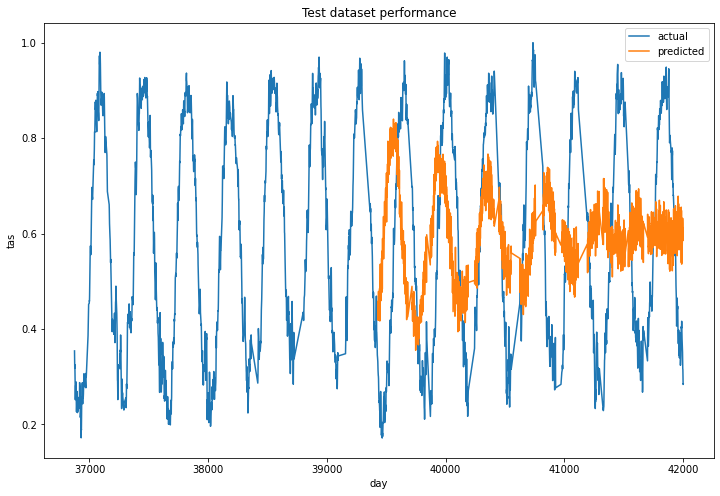

In [93]:
BACK_EXTEND = 4000
fc = df.copy()
# fc["tas"] = ts[-n_ahead:, -1]  # for if ts was replaced for testing
fc.reset_index(inplace=True)
pred = np.array([np.nan] * (BACK_EXTEND - len(yhat)) +  list(yhat))
plt.figure(figsize=(12, 8))
plt.plot(fc['day'][-BACK_EXTEND:], fc["tas"][-BACK_EXTEND:], label='actual')
plt.plot(fc['day'][-BACK_EXTEND:], pred, label='predicted')
plt.xlabel("day")
plt.ylabel("tas")
plt.title("Test dataset performance")
plt.legend()
plt.show()

In [86]:
# Save model
model.model.save("multi_lstm_2000")

INFO:tensorflow:Assets written to: multi_lstm_2000\assets


INFO:tensorflow:Assets written to: multi_lstm_2000\assets
